<a href="https://colab.research.google.com/github/dpark9941/lsd/blob/master/lsd/tutorial/notebooks/quick_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pooch required for skimage cells data
!pip install lsds pooch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.9 MB/s eta 0:00:00
  Created wheel for lsds: filen

In [2]:
import h5py
import io
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import skimage

from lsd.train import local_shape_descriptor
from scipy.ndimage import median_filter
from skimage.filters import sobel, threshold_li
from skimage.measure import label
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.segmentation import watershed

%matplotlib inline

## 2d Examples

* Labels in coins example generated following this [tutorial](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_expand_labels.html)

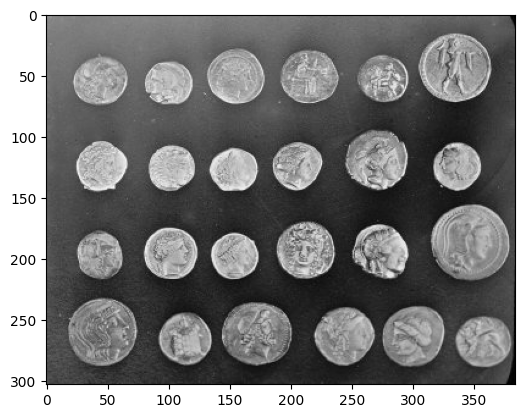

In [3]:
# get coins dataset
data = skimage.data.coins()

plt.imshow(data, cmap='gray')

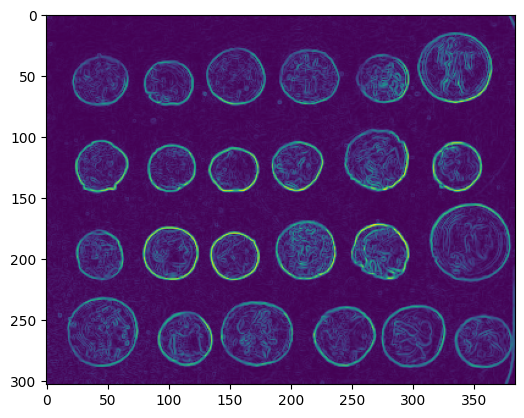

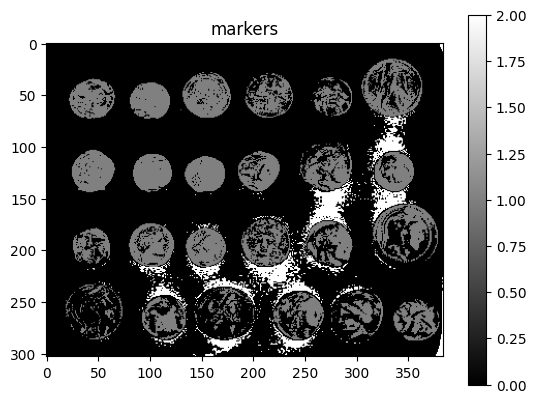

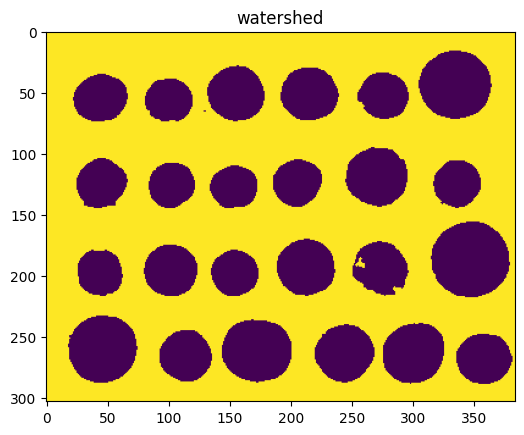

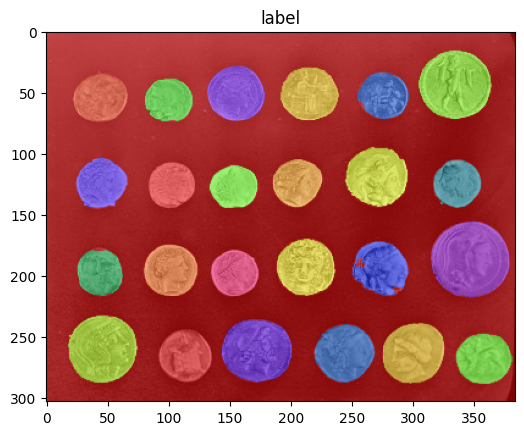

In [17]:
# create edges
edges = sobel(data)
plt.imshow(edges)
plt.show()

# generate markers for watershed
markers = np.zeros_like(data)
foreground, background = 1, 2
markers[data < 30.0] = background
markers[data > 150.0] = foreground
plt.imshow(markers, cmap='gray')
plt.colorbar()
plt.title("markers")
plt.show()

# get unique labels
ws = watershed(edges, markers)
labels = label(ws == foreground).astype(np.uint64)
plt.imshow(ws)
plt.title("watershed")
plt.show()
plt.imshow(data, cmap='gray')
plt.imshow(labels, cmap='prism', alpha=0.5)
plt.title("label")
plt.show()

In [18]:
# calculate lsds
lsds = local_shape_descriptor.get_local_shape_descriptors(
              segmentation=labels,
              sigma=(15,)*2,
              voxel_size=(1,)*2)

# 6 channels for 2d
print(lsds.shape)

(6, 303, 384)


In [19]:
def view_lsds(lsds):

  fig, axes = plt.subplots(
            2,
            3,
            figsize=(25, 10),
            sharex=True,
            sharey=True,
            squeeze=False)

  axes[0][0].imshow(np.squeeze(lsds[0]), cmap='jet')
  axes[0][0].title.set_text('Mean offset Y')

  axes[0][1].imshow(np.squeeze(lsds[1]), cmap='jet')
  axes[0][1].title.set_text('Mean offset X')

  axes[0][2].imshow(np.squeeze(lsds[2]), cmap='jet')
  axes[0][2].title.set_text('Covariance Y-Y')

  axes[1][0].imshow(np.squeeze(lsds[3]), cmap='jet')
  axes[1][0].title.set_text('Covariance X-X')

  axes[1][1].imshow(np.squeeze(lsds[4]), cmap='jet')
  axes[1][1].title.set_text('Covariance Y-X')

  axes[1][2].imshow(np.squeeze(lsds[5]), cmap='jet')
  axes[1][2].title.set_text('Size')

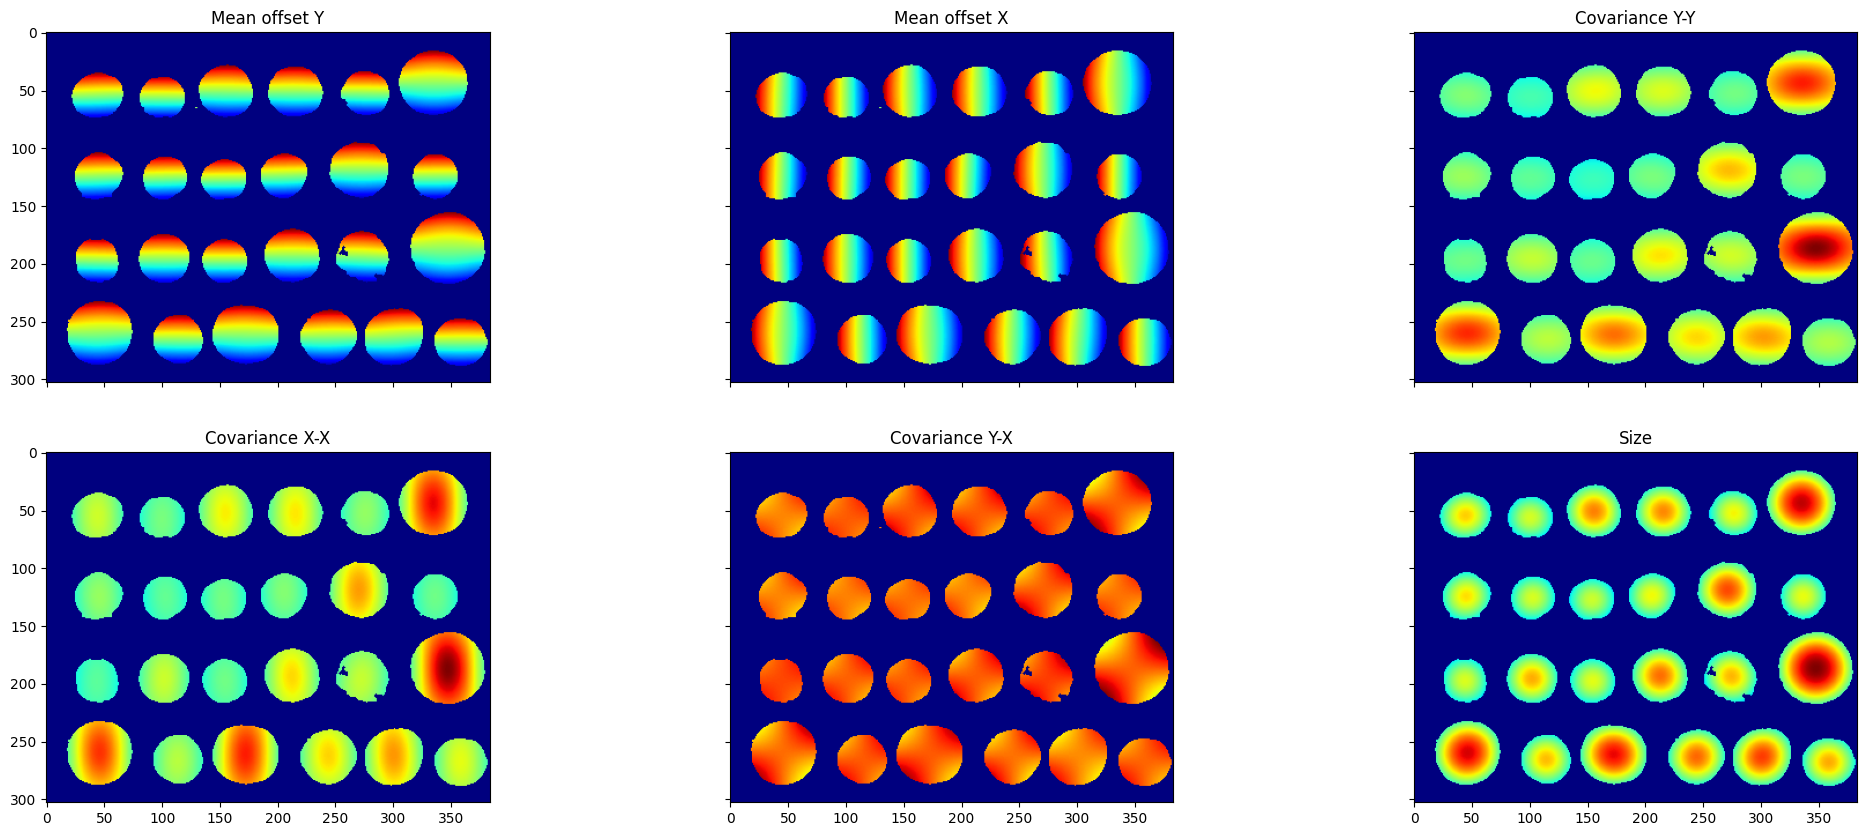

In [20]:
view_lsds(lsds)

In [25]:
# example data from cremi challenge - might take a couple seconds to download
url = 'https://cremi.org/static/data/sample_A_20160501.hdf'

# convert from binary
container = h5py.File(io.BytesIO(requests.get(url).content), 'r')

def print_hdf5_structure(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(f"[Dataset] {name} | shape: {obj.shape} | dtype: {obj.dtype}")
    elif isinstance(obj, h5py.Group):
        print(f"[Group] {name}")
container.visititems(print_hdf5_structure)



[Group] __DATA_TYPES__
[Group] annotations
[Group] annotations/comments
[Dataset] annotations/comments/comments | shape: (17,) | dtype: object
[Dataset] annotations/comments/target_ids | shape: (17,) | dtype: uint64
[Dataset] annotations/ids | shape: (432,) | dtype: uint64
[Dataset] annotations/locations | shape: (432, 3) | dtype: float32
[Group] annotations/presynaptic_site
[Dataset] annotations/presynaptic_site/partners | shape: (216, 2) | dtype: uint64
[Dataset] annotations/types | shape: (432,) | dtype: object
[Group] volumes
[Group] volumes/labels
[Dataset] volumes/labels/clefts | shape: (125, 1250, 1250) | dtype: uint64
[Dataset] volumes/labels/neuron_ids | shape: (125, 1250, 1250) | dtype: uint64
[Dataset] volumes/raw | shape: (125, 1250, 1250) | dtype: uint8


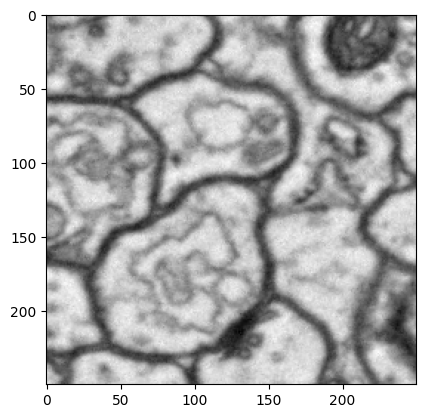

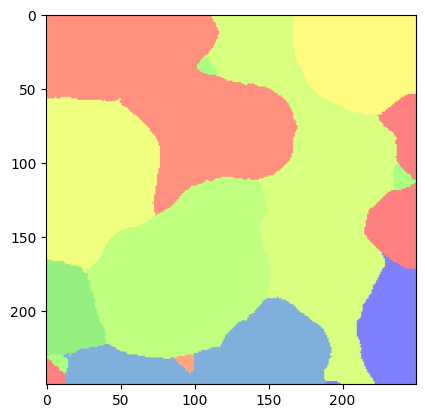

In [26]:
# get corner patch
raw = np.squeeze(container['volumes/raw'][0:1,0:250,0:250])
labels = np.squeeze(container['volumes/labels/neuron_ids'][0:1,0:250,0:250])

plt.figure(0)
plt.imshow(raw, cmap='gray')
plt.figure(1)
plt.imshow(labels, cmap='prism', alpha=0.5)

In [27]:
# calc lsds
lsds = local_shape_descriptor.get_local_shape_descriptors(
              segmentation=labels,
              sigma=(100,)*2,
              voxel_size=[4,4])

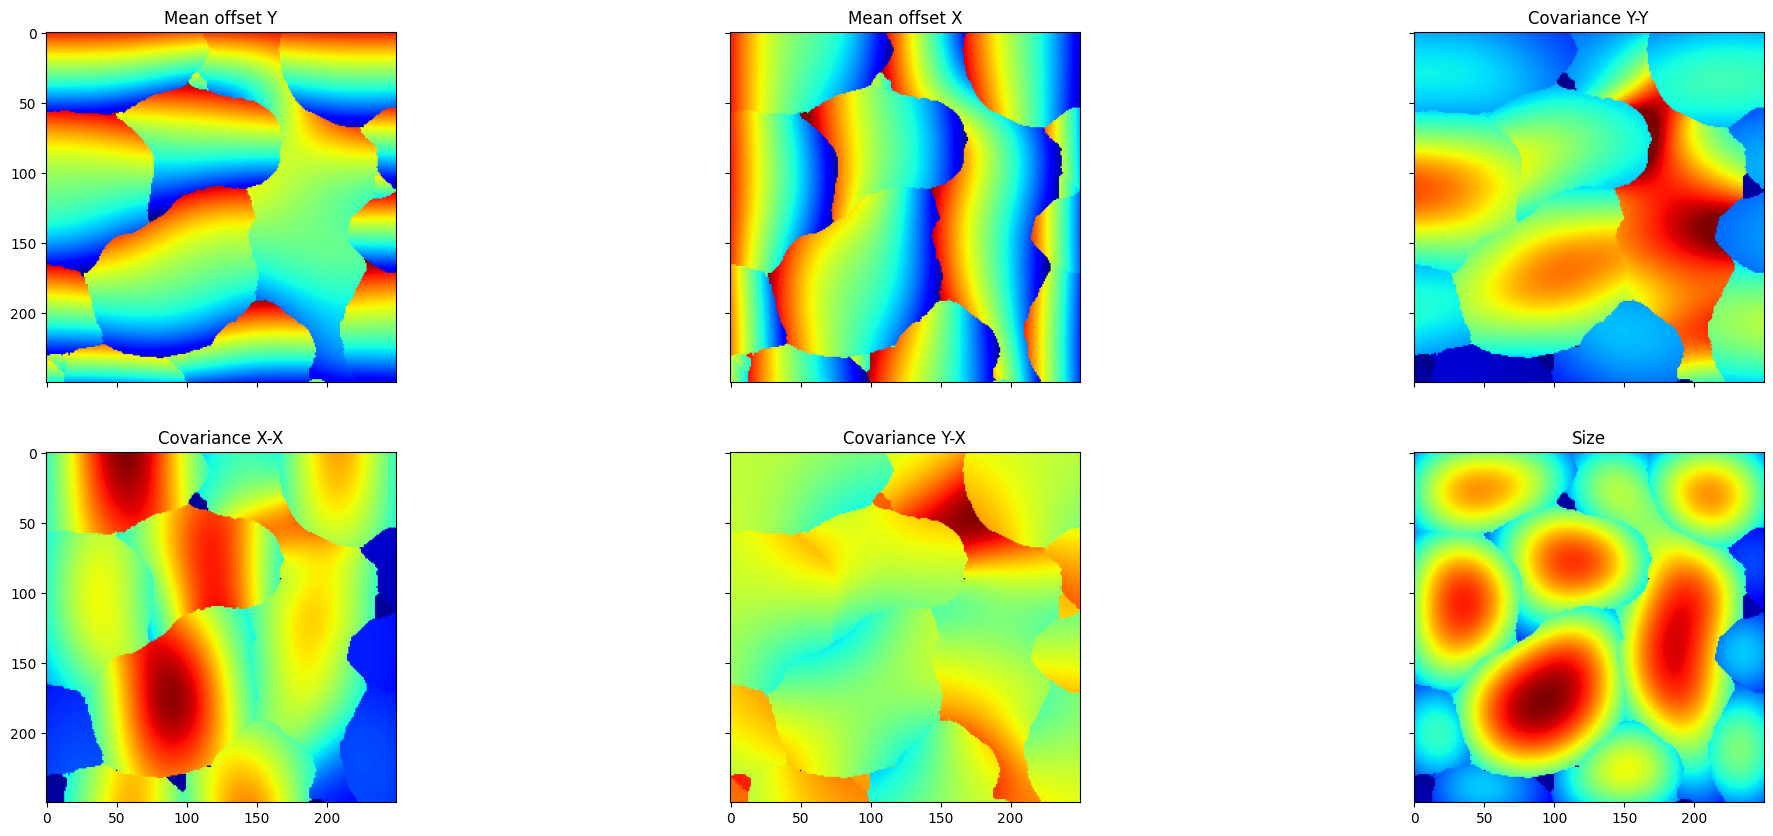

In [28]:
view_lsds(lsds)

## 3d example

* Labels created following the start of this [tutorial](https://jni.github.io/i2k-skimage-napari/lectures/2_segmentation_and_regionprops.html)
* There will be some falsely merged labels, but this should be a good starting point to see 3d lsds


(60, 256, 256)


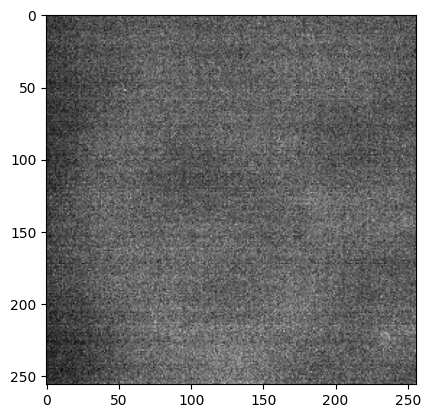

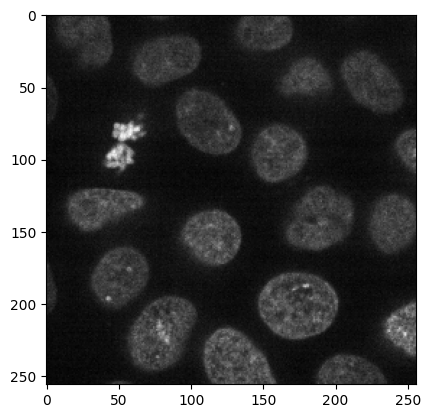

In [49]:
# get 3d cells data, use nuceli channel
data = skimage.data.cells3d()[:, 1]
print(data.shape)
plt.figure(1)
plt.imshow(data[0], cmap='gray')



# ignore end sections that don't contain cells
data = data[25:45]

norm = (data - data.min()) / (data.max() - data.min())
plt.figure(2)
plt.imshow(norm[0], cmap='gray')
# denoise
denoised = median_filter(data, size=3)

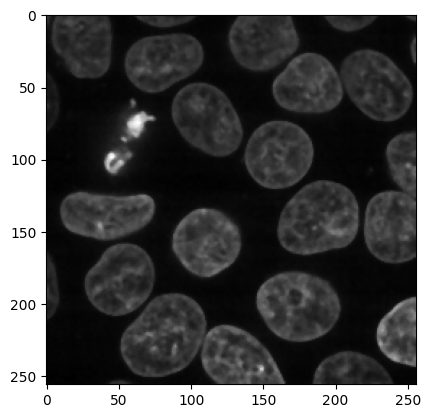

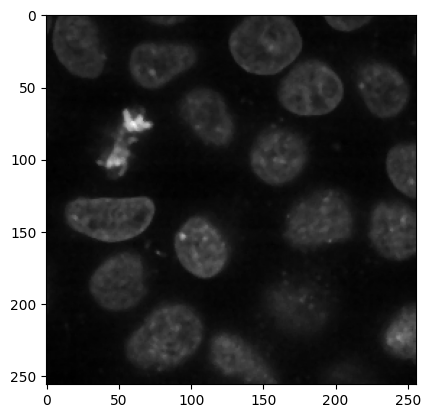

In [39]:
plt.figure(1)
plt.imshow(denoised[10], cmap='gray')
plt.figure(2)
plt.imshow(denoised[19], cmap='gray')

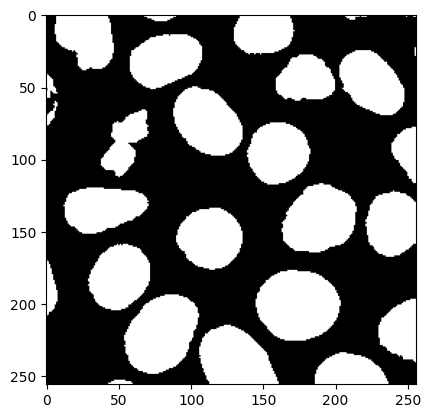

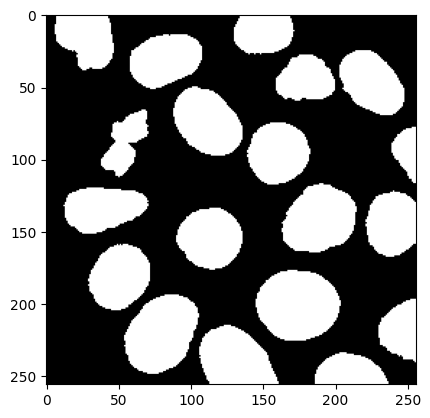

In [57]:
# create binary mask
thresholded = denoised > threshold_li(denoised)

# remove small holes and objects
remove_holes = remove_small_holes(thresholded, 20**3)
plt.figure(1)
plt.imshow(remove_holes[1], cmap='gray')


remove_objects = remove_small_objects(remove_holes, 20**3)
plt.figure(2)
plt.imshow(remove_objects[1], cmap='gray')

# relabel connected components
labels = label(remove_objects).astype(np.uint64)

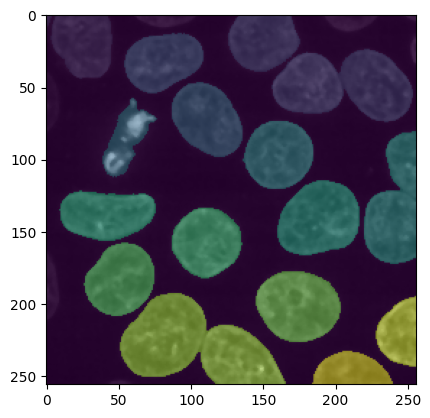

In [58]:
plt.imshow(denoised[10], cmap='gray')
plt.imshow(labels[10], alpha=0.5)

In [59]:
# take a random crop for efficiency
def random_crop(labels, crop_size):
    y = random.randint(0, labels.shape[1] - crop_size)
    x = random.randint(0, labels.shape[2] - crop_size)
    labels = labels[:, y:y+crop_size, x:x+crop_size]
    return labels

In [62]:
# calculate lsds
lsds = local_shape_descriptor.get_local_shape_descriptors(
                segmentation=random_crop(labels, 100),
                sigma=(5,) * 3,
                voxel_size=(1,) * 3)

(10, 20, 100, 100)


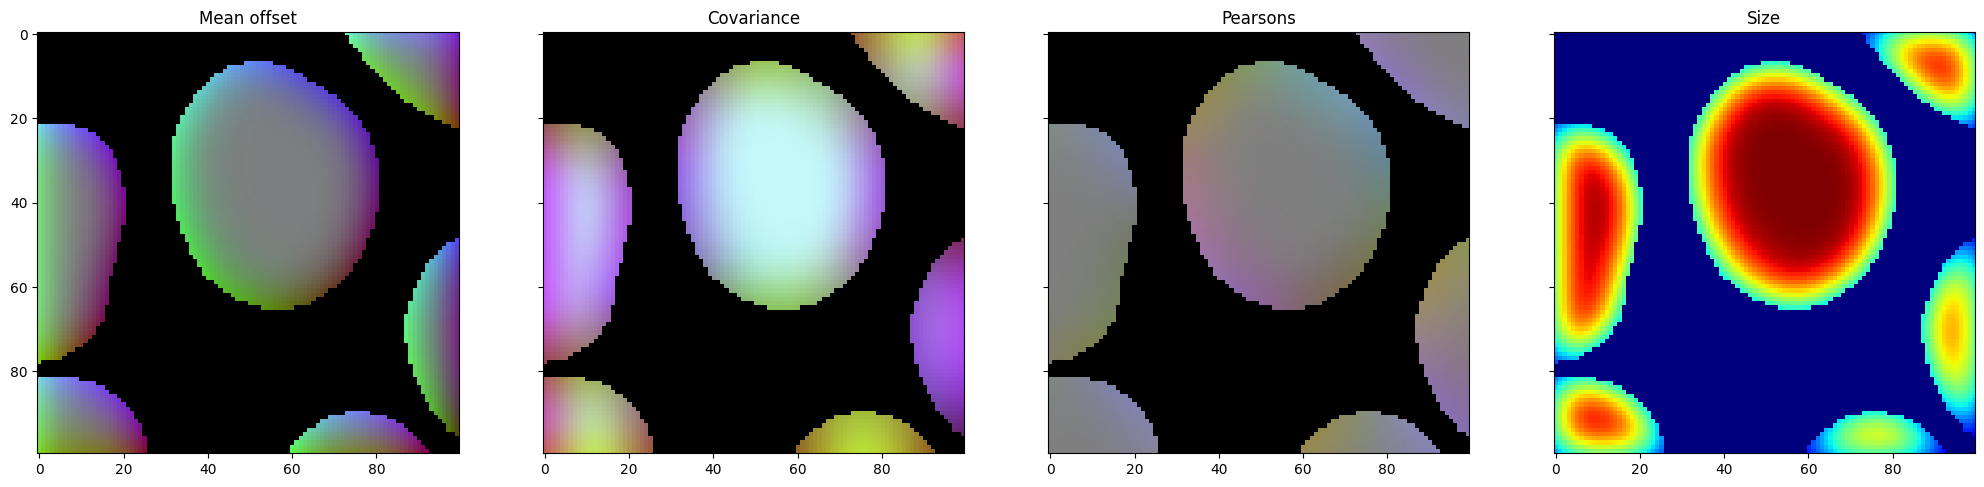

In [64]:
# view lsds (example section 10)
fig, axes = plt.subplots(
            1,
            4,
            figsize=(25, 10),
            sharex=True,
            sharey=True,
            squeeze=False)

# lsds are shape: c,z,y,x (where channels is now 10 dimensions)
# first 3 components can be rendered as rgb, matplotlib expects channels last
axes[0][0].imshow(lsds[0:3,10].T)
axes[0][0].title.set_text('Mean offset')

axes[0][1].imshow(lsds[3:6,10].T)
axes[0][1].title.set_text('Covariance')

axes[0][2].imshow(lsds[6:9,10].T)
axes[0][2].title.set_text('Pearsons')

axes[0][3].imshow(lsds[9,10].T, cmap='jet')
axes[0][3].title.set_text('Size')

print(lsds.shape)